# Clustering analysis on 10k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os, sys

sys.path.append('../src')

from imp import load_source
from models import *
from utils import *

tf.enable_eager_execution()
tf.executing_eagerly()

Using TensorFlow backend.



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters
# parameters = {
#     'latent_dim': 100,
#     'layers_enc_dim': [1000, 500, 400, 300, 200],
#     'layers_dec_dim': [200, 300, 400, 500, 1000],
#     'layers_dis_dim': [1000, 500, 400, 300, 200],
#     'batch_size': 1000,
#     'epochs': 20
# }

parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200],
    'layers_dec_dim': [200],
    'layers_dis_dim': [200],
    'batch_size': 1000,
    'epochs': 50
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,50,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [ ]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE1/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC10k/graphs/autoencoder.png)

### Train the model

In [11]:
# Create the input dataset
MODE = 'TFRecord'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [12]:
# Training...

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = False
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

Epoch 50/50, rec. loss: 0.796437, dis. loss: 0.636735
Training completed.
All networks exported in h5 format.


!tensorboard --logdir=../results/AAE1/PBMC10k/

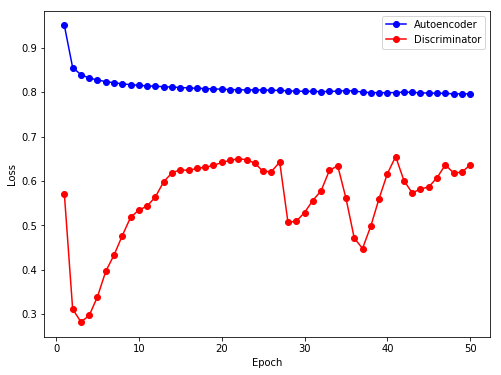

In [13]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

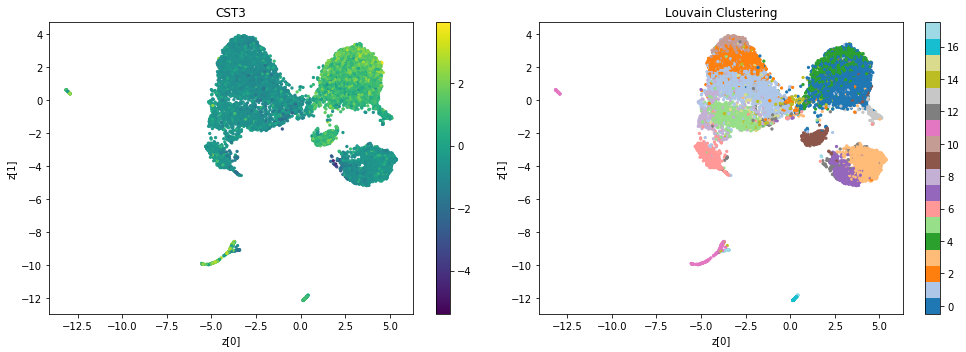

In [14]:
GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/AAE1/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
RES=0.9
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

In [23]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.adata.X)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


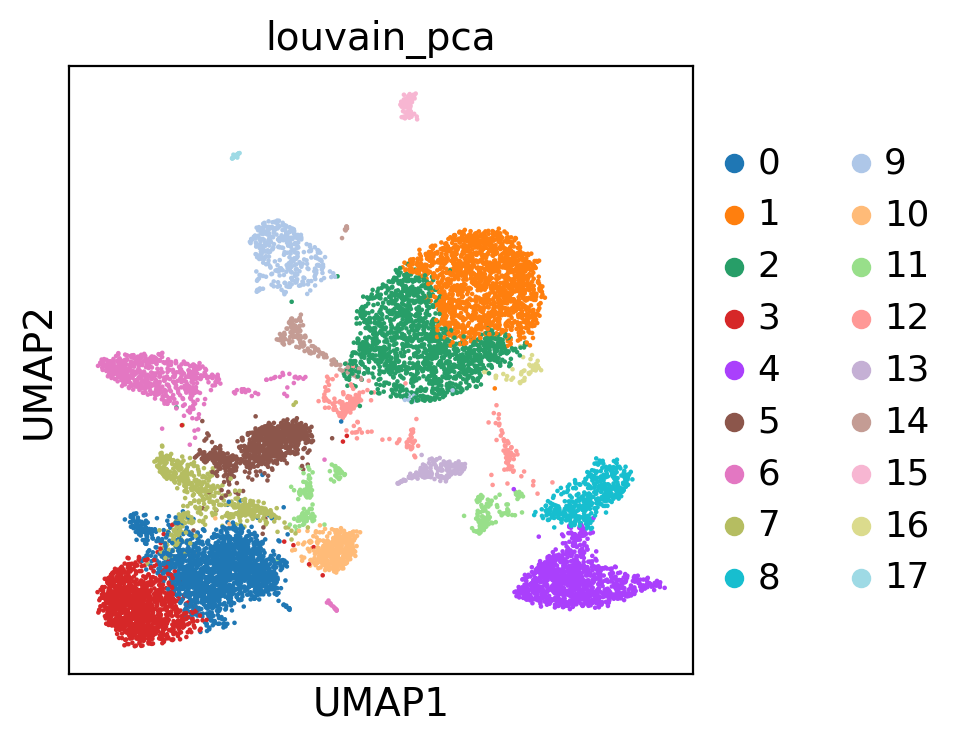

In [27]:
RES = 0.7
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

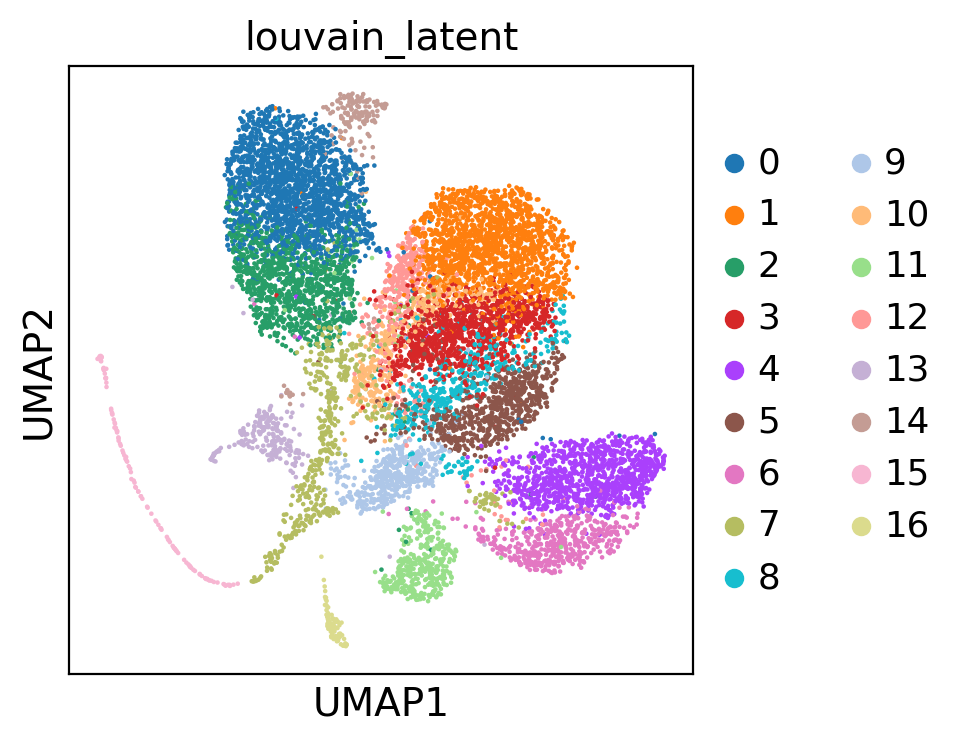

In [28]:
RES = 0.9
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [ ]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [ ]:
model = AAE2(**parameters)

In [ ]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

In [ ]:
# Rescale gene expression data

model.rescale_data()

In [ ]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

In [ ]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

In [ ]:
# Model summary

model.get_summary()

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC10k/graphs/autoencoder.png)

### Train the model


In [ ]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [ ]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

In [ ]:
RES=0.6
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [5]:
# Network parameters
# parameters = {
#     'latent_dim': 100,
#     'layers_enc_dim': [1000, 500, 400, 300, 200],
#     'layers_dec_dim': [200, 300, 400, 500, 1000],
#     'batch_size': 1000,
#     'epochs': 5000
# }
parameters = {
    'latent_dim': 10,
    'layers_enc_dim': [200],
    'layers_dec_dim': [200],
    'batch_size': 1000,
    'epochs': 500
}

In [6]:
model = VAE(**parameters)

In [7]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [8]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [9]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,500,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [10]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False
# TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
    strategy = tf.distribute.experimental.CentralStorageStrategy()
    
    with strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()
        
# elif TF_DISTRIBUTE_MULTI_WORKER_MIRRORED_STRATEGY:
    
#     import json
    
#     NUM_WORKERS = 2
#     IP_ADDRS = ['s42p35.deic.sdu.dk','s42p36.deic.sdu.dk']
# #     IP_ADDRS = ['localhost','localhost']
#     PORTS = [2223,2223]

#     os.environ['TF_CONFIG'] = json.dumps({
#         'cluster': {
#             'worker': ['%s:%d' % (IP_ADDRS[w], PORTS[w]) for w in range(NUM_WORKERS)]
#         },
#         'task': {'type': 'worker', 'index': 0}
#     })
    
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
#         tf.distribute.experimental.CollectiveCommunication.NCCL)
    
#     with strategy.scope():
    
#         NUM_WORKERS = 2
#         BATCH_SIZE_PER_REPLICA = model.batch_size
#         global_batch_size = (NUM_WORKERS * BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync)
#         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [ ]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/VAE/PBMC10k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC10k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC10k/graphs/autoencoder.png)

### Train the model

In [12]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc10k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 4 steps, validate for 1 steps
Epoch 1/500
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
4/4 [==============================] - 7s 2s/step - loss: 2486.6666 - val_loss: 2521.5872
Epoch 2/500
4/4 [==============================] - 0s 58ms/step - loss: 2456.0591 - val_loss: 2502.9590
Epoch 3/500
4/4 [==============================] - 0s 56ms/step - loss: 2419.7438 - val_loss: 2485.3550
Epoch 4/500
4/4 [==============================] - 0s 54ms/step - loss: 2392.7311 - val_loss: 2469.5420
Epoch 5/500
4/4 [==============================] - 0s 49ms/step - loss: 2361.9774 - val_loss: 2452.9709
Epoch 6/500
4/4 [==============================] - 0s 61ms/step - loss: 2336.9233 - val_loss: 2436.3618
Epoch 7/50

4/4 [==============================] - 0s 56ms/step - loss: 1856.0387 - val_loss: 1928.9336
Epoch 73/500
4/4 [==============================] - 0s 56ms/step - loss: 1864.1489 - val_loss: 1927.2252
Epoch 74/500
4/4 [==============================] - 0s 60ms/step - loss: 1855.8844 - val_loss: 1925.5835
Epoch 75/500
4/4 [==============================] - 0s 59ms/step - loss: 1855.4011 - val_loss: 1923.5139
Epoch 76/500
4/4 [==============================] - 0s 62ms/step - loss: 1846.8735 - val_loss: 1921.5029
Epoch 77/500
4/4 [==============================] - 0s 53ms/step - loss: 1847.3044 - val_loss: 1920.1145
Epoch 78/500
4/4 [==============================] - 0s 52ms/step - loss: 1853.2107 - val_loss: 1917.5854
Epoch 79/500
4/4 [==============================] - 0s 58ms/step - loss: 1843.8418 - val_loss: 1916.7727
Epoch 80/500
4/4 [==============================] - 0s 61ms/step - loss: 1858.1418 - val_loss: 1914.4856
Epoch 81/500
4/4 [==============================] - 0s 54ms/step - l

4/4 [==============================] - 0s 53ms/step - loss: 1798.9286 - val_loss: 1853.3555
Epoch 150/500
4/4 [==============================] - 0s 51ms/step - loss: 1808.2665 - val_loss: 1852.4419
Epoch 151/500
4/4 [==============================] - 0s 58ms/step - loss: 1808.5675 - val_loss: 1852.2161
Epoch 152/500
4/4 [==============================] - 0s 55ms/step - loss: 1811.6938 - val_loss: 1851.5793
Epoch 153/500
4/4 [==============================] - 0s 56ms/step - loss: 1799.9407 - val_loss: 1851.4438
Epoch 154/500
4/4 [==============================] - 0s 65ms/step - loss: 1804.9326 - val_loss: 1851.0664
Epoch 155/500
4/4 [==============================] - 0s 53ms/step - loss: 1806.2800 - val_loss: 1850.4553
Epoch 156/500
4/4 [==============================] - 0s 50ms/step - loss: 1799.0068 - val_loss: 1850.6769
Epoch 157/500
4/4 [==============================] - 0s 50ms/step - loss: 1799.2073 - val_loss: 1849.8308
Epoch 158/500
4/4 [==============================] - 0s 56ms

4/4 [==============================] - 0s 57ms/step - loss: 1785.6852 - val_loss: 1833.0920
Epoch 227/500
4/4 [==============================] - 0s 54ms/step - loss: 1789.2354 - val_loss: 1832.8417
Epoch 228/500
4/4 [==============================] - 0s 59ms/step - loss: 1776.4179 - val_loss: 1832.6738
Epoch 229/500
4/4 [==============================] - 0s 53ms/step - loss: 1785.3324 - val_loss: 1832.7327
Epoch 230/500
4/4 [==============================] - 0s 54ms/step - loss: 1782.8928 - val_loss: 1832.2461
Epoch 231/500
4/4 [==============================] - 0s 48ms/step - loss: 1787.5511 - val_loss: 1832.3037
Epoch 232/500
4/4 [==============================] - 0s 54ms/step - loss: 1790.3510 - val_loss: 1832.1223
Epoch 233/500
4/4 [==============================] - 0s 61ms/step - loss: 1790.8380 - val_loss: 1831.8103
Epoch 234/500
4/4 [==============================] - 0s 54ms/step - loss: 1782.9161 - val_loss: 1831.8455
Epoch 235/500
4/4 [==============================] - 0s 53ms

4/4 [==============================] - 0s 50ms/step - loss: 1783.4925 - val_loss: 1824.2371
Epoch 304/500
4/4 [==============================] - 0s 51ms/step - loss: 1773.2365 - val_loss: 1824.2363
Epoch 305/500
4/4 [==============================] - 0s 49ms/step - loss: 1782.8184 - val_loss: 1824.2183
Epoch 306/500
4/4 [==============================] - 0s 52ms/step - loss: 1772.9695 - val_loss: 1823.9949
Epoch 307/500
4/4 [==============================] - 0s 49ms/step - loss: 1788.9001 - val_loss: 1824.0850
Epoch 308/500
4/4 [==============================] - 0s 51ms/step - loss: 1775.0094 - val_loss: 1823.9717
Epoch 309/500
4/4 [==============================] - 0s 49ms/step - loss: 1771.3629 - val_loss: 1824.1405
Epoch 310/500
4/4 [==============================] - 0s 57ms/step - loss: 1772.1715 - val_loss: 1823.6729
Epoch 311/500
4/4 [==============================] - 0s 60ms/step - loss: 1775.7457 - val_loss: 1823.6321
Epoch 312/500
4/4 [==============================] - 0s 53ms

4/4 [==============================] - 0s 53ms/step - loss: 1770.7946 - val_loss: 1819.6042
Epoch 381/500
4/4 [==============================] - 0s 48ms/step - loss: 1765.9510 - val_loss: 1819.6444
Epoch 382/500
4/4 [==============================] - 0s 56ms/step - loss: 1766.2995 - val_loss: 1819.6284
Epoch 383/500
4/4 [==============================] - 0s 54ms/step - loss: 1766.8115 - val_loss: 1819.4543
Epoch 384/500
4/4 [==============================] - 0s 51ms/step - loss: 1777.5657 - val_loss: 1819.2375
Epoch 385/500
4/4 [==============================] - 0s 60ms/step - loss: 1773.0521 - val_loss: 1819.3945
Epoch 386/500
4/4 [==============================] - 0s 52ms/step - loss: 1779.4184 - val_loss: 1819.2937
Epoch 387/500
4/4 [==============================] - 0s 58ms/step - loss: 1769.6324 - val_loss: 1819.5044
Epoch 388/500
4/4 [==============================] - 0s 56ms/step - loss: 1771.2326 - val_loss: 1818.8472
Epoch 389/500
4/4 [==============================] - 0s 51ms

4/4 [==============================] - 0s 60ms/step - loss: 1769.9361 - val_loss: 1816.6436
Epoch 458/500
4/4 [==============================] - 0s 54ms/step - loss: 1771.6232 - val_loss: 1816.6067
Epoch 459/500
4/4 [==============================] - 0s 51ms/step - loss: 1763.6199 - val_loss: 1816.6490
Epoch 460/500
4/4 [==============================] - 0s 59ms/step - loss: 1778.7774 - val_loss: 1816.5723
Epoch 461/500
4/4 [==============================] - 0s 55ms/step - loss: 1758.3805 - val_loss: 1816.2441
Epoch 462/500
4/4 [==============================] - 0s 54ms/step - loss: 1766.3011 - val_loss: 1816.2769
Epoch 463/500
4/4 [==============================] - 0s 52ms/step - loss: 1764.2762 - val_loss: 1816.2529
Epoch 464/500
4/4 [==============================] - 0s 53ms/step - loss: 1763.9022 - val_loss: 1816.5085
Epoch 465/500
4/4 [==============================] - 0s 53ms/step - loss: 1766.7628 - val_loss: 1816.3037
Epoch 466/500
4/4 [==============================] - 0s 60ms

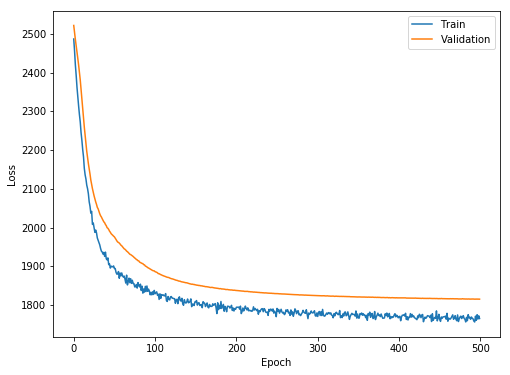

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

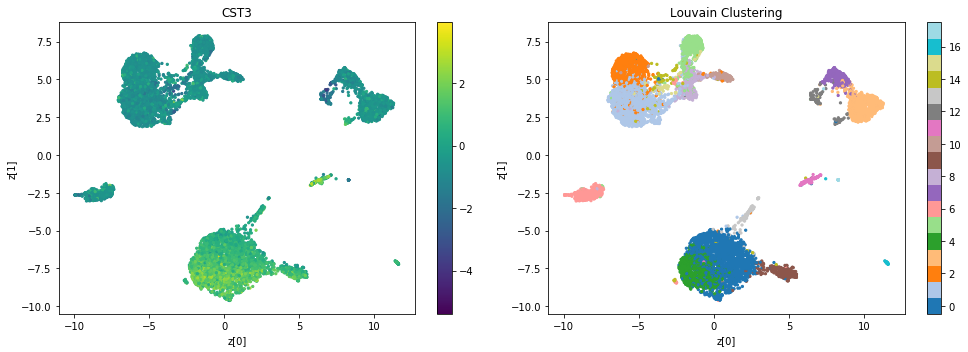

In [14]:
gene_list = ['CST3']
model.plot_umap(gene_selected=gene_list, louvain=True)

In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/VAE/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

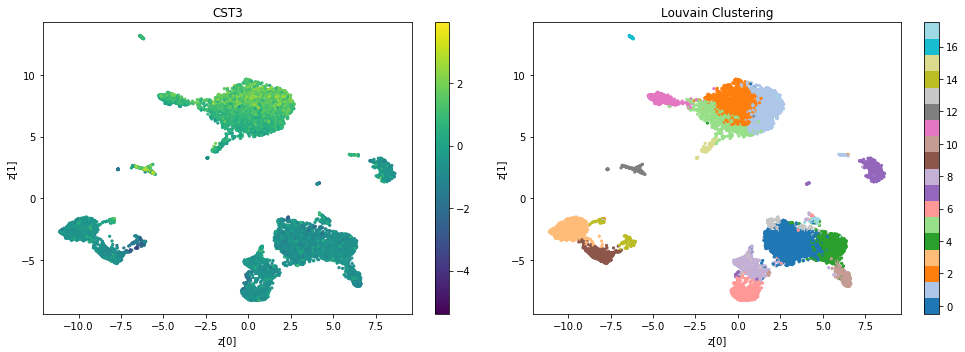

ARI = 0.6239047712480933
AMI = 0.7612194067981115


In [19]:
RES=0.9
N_NBS=10
N_PCS=40

model.update_labels(res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

In [29]:
def plot_louvain(self, use_rep='X', res=1.0, n_neighbors=10, n_pcs=40):

        """Cluster cells using the Louvain algorithm and update model labels

        """
        import scanpy as sc
        
        sc.settings.set_figure_params(dpi=100)
        
        if use_rep == 'X':
            
            X = sc.AnnData(self.data)
            
            sc.tl.pca(X, svd_solver='arpack')

            sc.pp.neighbors(X, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(X, key_added="louvain_pca", resolution=res)
        
            sc.tl.umap(X)

            sc.pl.umap(X, color=["louvain_pca"], show=True)
            
        elif use_rep == 'Z':
            
            
            encoder_model = Model(inputs=self.autoencoder.layers[1].get_layer('X').input,
                                  outputs=self.autoencoder.layers[1].get_layer('z_mean').output)

            latent = encoder_model(self.data).numpy()

            Z = sc.AnnData(latent)

            sc.tl.pca(Z, svd_solver='arpack')

            sc.pp.neighbors(Z, n_neighbors=n_neighbors, n_pcs=n_pcs)

            sc.tl.louvain(Z, key_added="louvain_latent", resolution=res)
        
            sc.tl.umap(Z)

            sc.pl.umap(Z, color=["louvain_latent"], show=True)
            
        else:
            
            print("Use repressentation 'X' or 'Z'.")


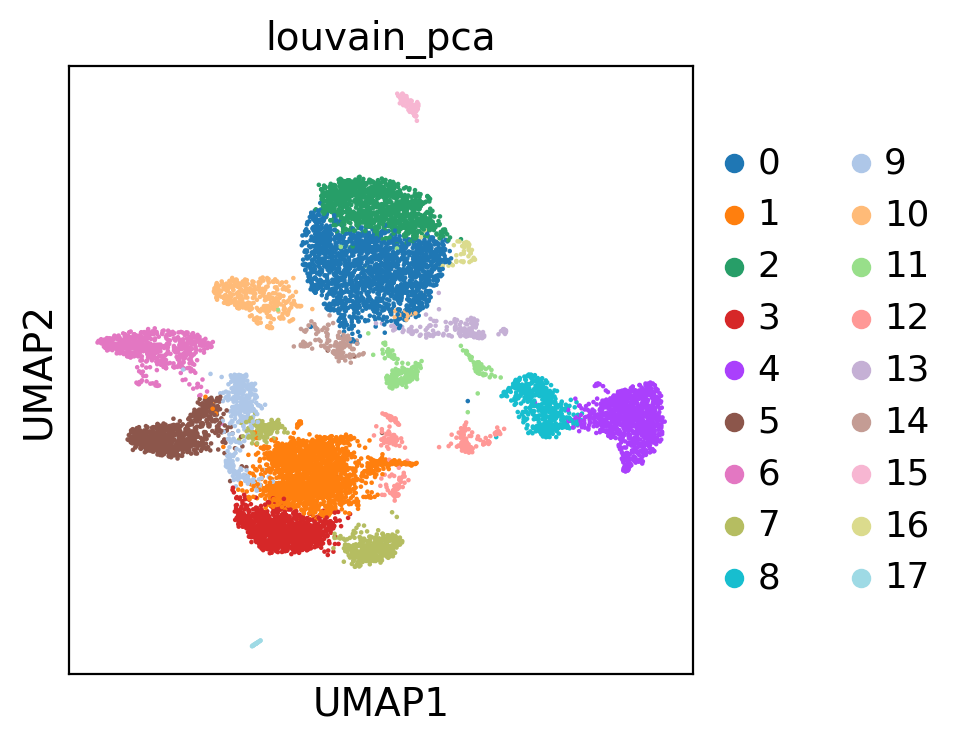

In [30]:
RES = 0.5
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='X', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)

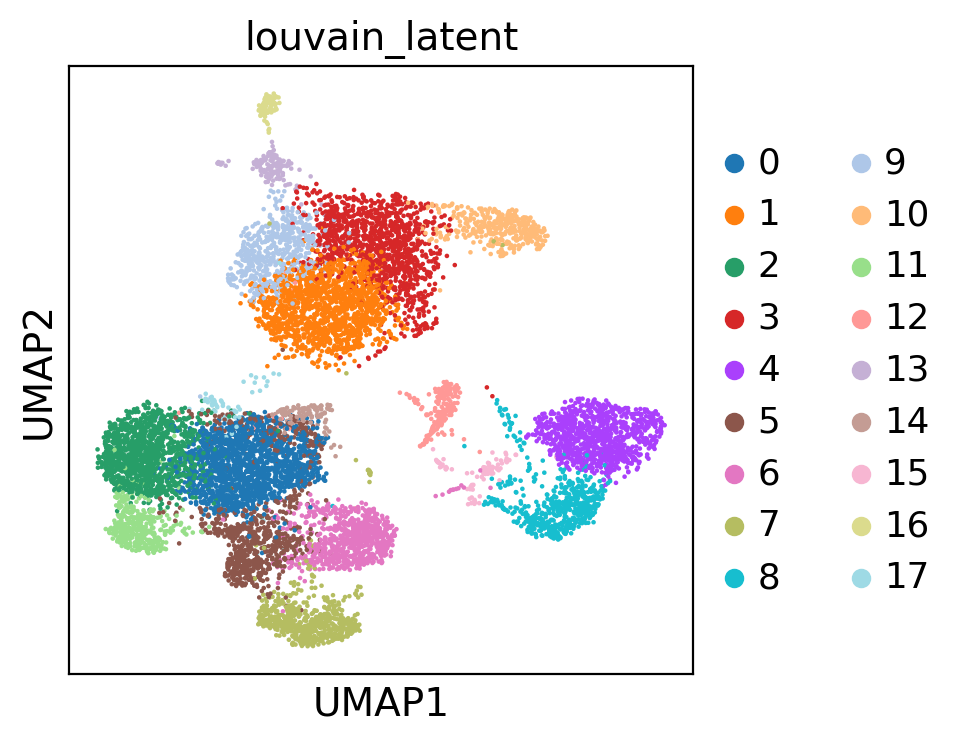

In [32]:
RES = 1.0
N_NBS = 10
N_PCS = 40

plot_louvain(model, use_rep='Z', res=RES, n_neighbors=N_NBS, n_pcs=N_PCS)